In the paper, short-term plasticity is caluculated accroding to equation (6):


$$
k_1 = \frac{1-y}{\tau_h}
$$

$$
k_2 = \frac{1-y+0.5 h_{sd} k_1}{\tau_h}
$$

$$
k_3 = \frac{1-y+0.5 h_{sd} k_2}{\tau_h}
$$

$$
k_4 = \frac{1 - y + h_{sd} k_3}{\tau_h}
$$

$$
y \leftarrow  \frac {h_{sd} (k_1 + 2 k_2 + 2 k_3 + k_4)}{6}
$$


whereas in the c++ code that I got from the lab server (and hopefully understood correctly) the short-term plasticity is calculated using very different equations. $h_{sd}$ according to the c++ code equals 0.1.

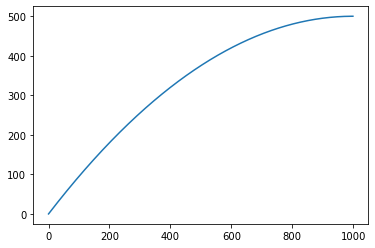

In [17]:
import matplotlib.pyplot as plt

Ip = 1.0
u = -0.625

t2 = 16000
tdur = 1000

U = []
for t in range(t2, t2+tdur):
    u += Ip*(t2+tdur - t)/tdur;
    U.append(u)

plt.plot(U)

In [2]:
with open('/Users/romankoshkin/Downloads/binary_model_r_al50_u10_i150_a90_b30_k0.txt', 'r') as f:
    a = f.readlines()
A = []
for line in a:
    A.append(line.split(' '))
grouped = {}
for time, idx in A:
    grouped.setdefault(float(time), []).append(int(idx))

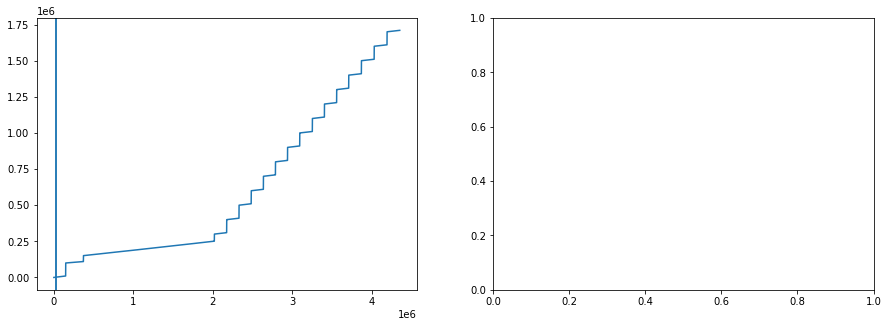

In [56]:
%matplotlib inline
t0, t1 = 31000, 33000

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(list(grouped.keys()))
plt.axvline(t0)
plt.axvline(t1)

plt.subplot(1,2,2)
for t in grouped.keys():
    if (t0 < t ) & (t < t1):
        plt.plot(t * np.ones(len(grouped[t])), grouped[t], '.', c='b')

plt.show()

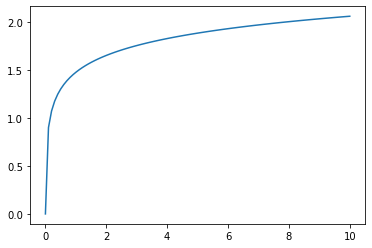

In [30]:
a = 50.0
J = np.linspace(0,10,100)
JEE = 0.15

f = np.log(1+a*J/JEE)/np.log(1+a)
plt.plot(J, f)



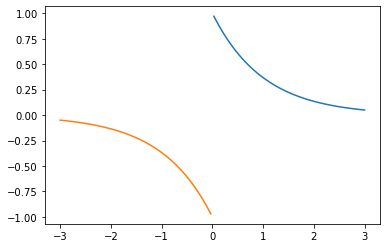

In [54]:
post = np.zeros((100,))
pre = np.linspace(-3,3,100)

t = post-pre

# potentiation (if t_pre < t_post)
plt.plot(t[t>0], np.exp(-t[t>0]))

# depression (if t_pre > t_post)
plt.plot(t[t<=0], -np.exp(t[t<=0]))

In [35]:
prepost[prepost<=0]

array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303])

# My python wrapper over a C++ implementation

In [1]:
import time, sys
import numpy as np
from cClasses import cClassOne
import matplotlib.pyplot as plt
from termcolor import colored


params = {
    "alpha": 50.0,    # Degree of log-STDP (50.0)
    "usd": 0.1,       # Release probability of a synapse (0.05 - 0.5)
    "JEI": 0.15,      # 0.15 or 0.20
    "ita": 2,           # stim A duration, s (90)
    "itb": 2,           # stim B duration, s (30)

    "T": 1800*1000.0,   # simulation time, ms
    "h": 0.01,          # time step, ms ??????

    # probability of connection
    "cEE": 0.2, # 
    "cIE": 0.2, #
    "cEI": 0.5, #
    "cII": 0.5, #

    # Synaptic weights
    "JEE": 0.15, #
    "JEEinit": 0.18, # ?????????????
    "JIE": 0.15, # 
    "JII": 0.06, #
    
    #initial conditions of synaptic weights
    "JEEh": 0.15, # Standard synaptic weight E-E
    "sigJ": 0.3,  #

    "Jtmax": 0.25, # J_maxˆtot
    "Jtmin": 0.01, # J_minˆtot # ??? NOT IN THE PAPER

    # Thresholds of update
    "hE": 1.0, # Threshold of update of excitatory neurons
    "hI": 1.0, # Threshold of update of inhibotory neurons

    "IEex": 2.0, # Amplitude of steady external input to excitatory neurons
    "IIex": 0.5, # Amplitude of steady external input to inhibitory neurons
    "mex": 0.3,        # mean of external input
    "sigex": 0.1,      # variance of external input

    # Average intervals of update, ms
    "tmE": 5.0,  #t_Eud EXCITATORY
    "tmI": 2.5,  #t_Iud INHIBITORY
    
    #Short-Term Depression
    "trec": 600.0,     # recovery time constant (tau_sd, p.13 and p.12)
    "Jepsilon": 0.001, # ????????
    
    # Time constants of STDP decay
    "tpp": 20.0,  # tau_p
    "tpd": 40.0,  # tau_d
    "twnd": 500.0, # STDP window lenght, ms
    
    "g": 1.25,        # ??????
    
    #homeostatic
    "itauh": 100,		# decay time of homeostatic plasticity, (100s)
    "hsd": 0.1,
    "hh": 10.0,  # SOME MYSTERIOUS PARAMETER
    "Ip": 1.0, # External current applied to randomly chosen excitatory neurons
    "a": 0.20, # Fraction of neurons to which this external current is applied
    
    "xEinit": 0.02, # the probability that an excitatory neurons spikes at the beginning of the simulation
    "xIinit": 0.01, # the probability that an inhibitory neurons spikes at the beginning of the simulation
    "tinit": 1.00, # period of time after which STDP kicks in (100.0)
    "tdur": 1000.0,
    "t1": 1.0,   # stim 1 onset (s)
    "U": 0.6,
    "taustf": 200,
    "taustd": 500,
    "HAGA": True,
    "asym": True,
    "interstitial": 2.0    
} 

In [2]:
NE = 2500
NI = 500

params['t1'] = 1
params['ita'] = 3
params['itb'] = 3
params['HAGA'] = True
if params['HAGA'] == True:
    params['g'] = 2.5
# params['usd'] = 0.6

# params['SNE'] = 5
# params['SNI'] = 2
# params['Ip'] = 15
# params['hI'] = 2

# params['cEI'] = 0.3
# params['cIE'] = 0.1
# # params['cII'] = 0.5
# # params['cEE'] = 0.1


# params['JII'] = 0.02

# params['JEI'] = 0.01
# params['JIE'] = 0.05
# params['JEE'] = 0.25

# params['IEex'] = 1.0
# params['IIex'] = 1.0

m = cClassOne(NE, NI)
m.setParams(params)
ret = m.getState()

# check if the parameters have been set:
for var_name in params.keys():
    if params[var_name] != getattr(ret, var_name):
        print("{} doesn't match".format(var_name))
m.setParams(params)

ret = m.getState()
[(attr, getattr(ret, attr)) for attr in dir(ret) if attr[0]!="_"]

t1 doesn't match


[('Cd', 0.0075),
 ('Cp', 0.015),
 ('HAGA', True),
 ('IEex', 2.0),
 ('IIex', 0.5),
 ('Ip', 1.0),
 ('JEE', 0.15),
 ('JEEh', 0.15),
 ('JEEinit', 0.18),
 ('JEI', 0.15),
 ('JIE', 0.15),
 ('JII', 0.06),
 ('Jepsilon', 0.001),
 ('Jmax', 0.75),
 ('Jmin', 0.0015),
 ('Jtmax', 0.25),
 ('Jtmin', 0.01),
 ('NE', 2500),
 ('NEa', 500),
 ('NI', 500),
 ('SNE', 5),
 ('SNI', 2),
 ('T', 1800000.0),
 ('U', 0.6),
 ('a', 0.2),
 ('alpha', 50.0),
 ('asym', True),
 ('cEE', 0.2),
 ('cEI', 0.5),
 ('cIE', 0.2),
 ('cII', 0.5),
 ('g', 2.5),
 ('h', 0.01),
 ('hE', 1.0),
 ('hI', 1.0),
 ('hh', 10.0),
 ('hsd', 0.1),
 ('interstitial', 2.0),
 ('ita', 3),
 ('itauh', 100),
 ('itb', 3),
 ('mex', 0.3),
 ('sigJ', 0.3),
 ('sigex', 0.1),
 ('t', 0.0),
 ('t1', 1000.0),
 ('t2', 4000.0),
 ('t3', 5000.0),
 ('t4', 8000.0),
 ('taustd', 500.0),
 ('taustf', 200.0),
 ('tdur', 1000.0),
 ('tinit', 1.0),
 ('tmE', 5.0),
 ('tmI', 2.5),
 ('tpd', 40.0),
 ('tpp', 20.0),
 ('trec', 600.0),
 ('twnd', 500.0),
 ('usd', 0.1),
 ('xEinit', 0.02),
 ('xIinit'

array([[ 0.036 , -0.0748],
       [ 0.03  , -0.0299]])

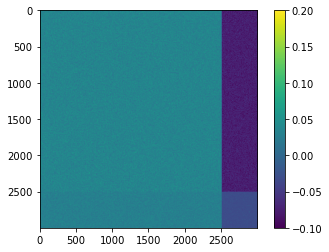

In [3]:
W = m.getWeights()
plt.imshow(W, origin='upper', vmin=-0.1, vmax=0.2)
plt.colorbar()
a = W[:NE, :NE].mean() # EE
b = W[:NE, NE:].mean() # IE
c = W[NE:, NE:].mean() # II
d = W[NE:, :NE].mean() # EI



np.array([[a, b], [d, c]]).round(4)

In [4]:
sim_t = 15
snapshotEveryMs = 1000

W = []
W.append(m.getWeights())
for i in range(int(sim_t*1000/snapshotEveryMs)):
    t = time.time()
        
    # simulate for the number of steps that are in 1000 ms (1 s)
    m.sim(int(snapshotEveryMs / params['h']))
   
    # get the states
    ret = m.getState()
    print('Elapsed {:.3f} s. per 1 s. of simulated time | t = {:.2f}'.format(time.time() - t, ret.t))
    t = time.time()
    
#     if (ret.t > 4900) & (ret.t < 5100):
#         print([(attr, getattr(ret, attr)) for attr in dir(ret) if attr[0]!="_"])
#         params['g'] = 1.25
#         m.setParams(params)
#         ret = m.getState()
#         print([(attr, getattr(ret, attr)) for attr in dir(ret) if attr[0]!="_"])
    
    # take a snapshot of the weight matrix
    W.append(m.getWeights())
print("Memory footprint of W is {:.2f} MB".format(
    np.sum([W[i].size * W[i].itemsize / 1024**2 for i in range(len(W))])))

Elapsed 5.997 s. per 1 s. of simulated time | t = 1000.00
Elapsed 6.311 s. per 1 s. of simulated time | t = 2000.00
Elapsed 6.231 s. per 1 s. of simulated time | t = 3000.00
Elapsed 6.573 s. per 1 s. of simulated time | t = 4000.00
Elapsed 6.267 s. per 1 s. of simulated time | t = 5000.00
Elapsed 6.447 s. per 1 s. of simulated time | t = 6000.00
Elapsed 6.642 s. per 1 s. of simulated time | t = 7000.00
Elapsed 6.451 s. per 1 s. of simulated time | t = 8000.00
Elapsed 6.474 s. per 1 s. of simulated time | t = 9000.00
Elapsed 7.679 s. per 1 s. of simulated time | t = 10000.00
Elapsed 6.258 s. per 1 s. of simulated time | t = 11000.00
Elapsed 6.184 s. per 1 s. of simulated time | t = 12000.00
Elapsed 6.000 s. per 1 s. of simulated time | t = 13000.00
Elapsed 6.027 s. per 1 s. of simulated time | t = 14000.00
Elapsed 6.069 s. per 1 s. of simulated time | t = 15000.00
Memory footprint of W is 1098.63 MB


0 186198


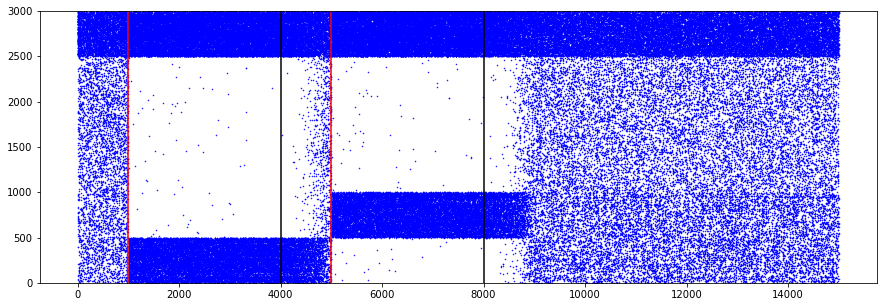

In [5]:
k = 15
with open('spike_times.txt', 'r') as f:
    lines = f.readlines()

t, idx = [], []
for i, line in enumerate(lines):
    line = line[:-1].split(' ')
    t.append(float(line[0]))
    idx.append(int(line[1]))
    
t_ = np.array(t)
for i in range(0, int(sim_t*1000/snapshotEveryMs), k):
    plt.figure(figsize=(15,5))
    lim1, lim2 = np.argmin(np.abs(t_ - i*snapshotEveryMs)), np.argmin(np.abs(t_ - (i+k)*snapshotEveryMs))
    print(lim1, lim2)
    plt.plot(t[lim1:lim2], idx[lim1:lim2], 'bo', ms=0.5)
    plt.ylim(0, W[0].shape[0])
plt.axvline(ret.t1, c='r')
plt.axvline(ret.t2, c='k')
plt.axvline(ret.t3, c='r')
plt.axvline(ret.t4, c='k')

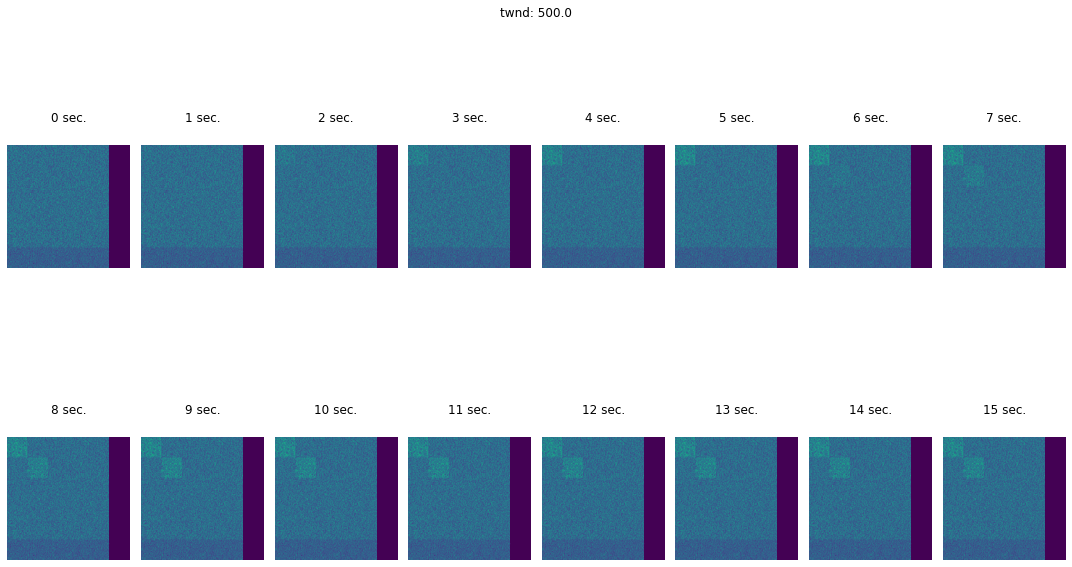

In [6]:
plt.figure(figsize=(15,10))
for i in range(len(W)):
    plt.subplot(2, np.ceil(len(W)/2), i+1)
    plt.imshow(W[i], origin='upper', vmin=0, vmax=0.1)
    plt.title('{} sec.'.format(i))
    plt.axis('off')
    plt.gca().xaxis.tick_top()
plt.suptitle('twnd: {}'.format(m.getState().twnd))

plt.tight_layout()

array([[ 0.0362, -0.0748],
       [ 0.03  , -0.0299]])

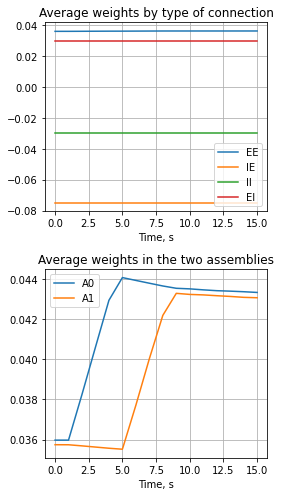

In [7]:
A, B, C, D, A0, A1 = [],[],[],[],[],[]
for i in range(len(W)):
    a = W[i][:NE, :NE].mean() # EE
    b = W[i][:NE, NE:].mean() # IE
    c = W[i][NE:, NE:].mean() # II
    d = W[i][NE:, :NE].mean() # EI
    as0 = W[i][:500, :500].mean() # assebly 0
    as1 = W[i][500:1000, 500:1000].mean() # assebly 1
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    A0.append(as0)
    A1.append(as1)

plt.figure(figsize=(4,7))
plt.subplot(2,1,1)
plt.plot(A, label='EE')
plt.plot(B, label='IE')
plt.plot(C, label='II')
plt.plot(D, label='EI')
plt.title('Average weights by type of connection')
plt.xlabel('Time, s')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(2,1,2)
plt.plot(A0, label='A0')
plt.plot(A1, label='A1')
plt.legend()
plt.title('Average weights in the two assemblies')
plt.xlabel('Time, s')
plt.grid()
plt.tight_layout()

np.array([[a, b], [d, c]]).round(4)

No handles with labels found to put in legend.


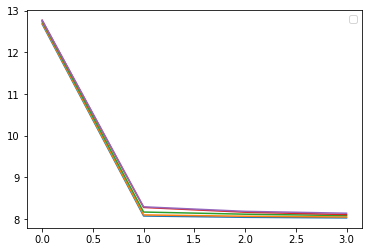

In [7]:
# Eigenvalues of the weight matrix. The first two prominent eigenvalues correspond to the neural assemblies
S = []
for i in range(len(W)):
    u,s,v = np.linalg.svd(W[i])
    S.append(s)
for s in S:
    plt.plot(s[1:5])
plt.legend()

(array([0.22403693, 0.52160394, 0.60202745, 0.45312906, 0.28745662,
        0.13212435, 0.0569858 , 0.01539536, 0.00390628, 0.00114891]),
 array([0.01879668, 0.45399278, 0.88918888, 1.32438499, 1.75958109,
        2.19477719, 2.62997329, 3.06516939, 3.5003655 , 3.9355616 ,
        4.3707577 ]),
 <a list of 10 Patch objects>)

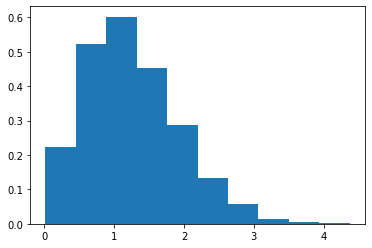

In [11]:
# sampling from the standard normal dist based on two independent uniformly distributed variables
import time, sys
import numpy as np
from cClasses import cClassOne
import matplotlib.pyplot as plt

def ngn():
    u = np.random.rand();
    v = np.random.rand();
    return np.sqrt(-2.0*np.log(u)) #* np.cos(2.0*np.pi*v);
I = []
for i in range(10000):
    I.append(ngn())
    
plt.hist(I, density=True)

# Issues & Questions
- the network must be balanced (no runaway activity in a network of a given size)
- why, when we stimulate one subset of excitatory neurons, the other excitatory neurons' activity is depressed?
- what is mean-field approximation?

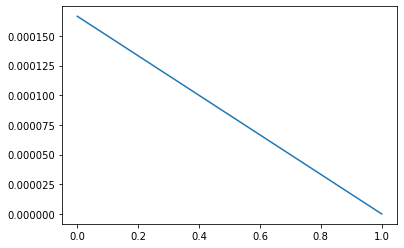

In [36]:
def Dys(ys):
    hsd = 0.1
    trec = 600.0
    k1 = (1.0 - ys) / trec
    k2 = (1.0 - (ys+0.5*hsd*k1)) / trec
    k3 = (1.0 - (ys+0.5*hsd*k2)) / trec
    k4 = (1.0 - (ys+hsd*k3)) / trec
    dys = hsd*(k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0
    return dys
    
dys = []
ys = np.linspace(0, 1, 100).tolist()
for ys_ in ys:
    dys.append(Dys(ys_))
plt.plot(ys, dys)
    

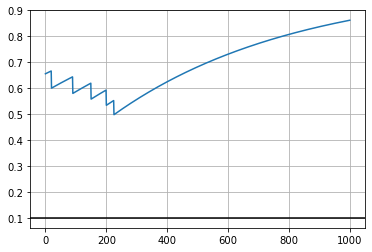

In [13]:
ys = [0.655]
usd = 0.1
tausd = 600
T = np.arange(0,1000, 1)
for t in T:
    ys_ = (1 - ys[-1]) / tausd
    if t in np.array([20, 90, 150, 200, 225]):
        ys_ -= usd * ys[-1]
    ys.append(ys[-1] + ys_)
    
plt.plot(T, ys[1:])
plt.grid()
plt.axhline(usd, c='k')



In [1]:
F = [0]
D = [1]
I = [0]

usd = 0.6  # initial release probability
U = 0.45 # decrement on spike
taustf = 50
taustd = 750
taus = 20
T = np.arange(0, 1000, 1)
spts = np.array([20, 90, 150, 200, 225])

for t in T:
    f = (usd - F[-1]) / taustf
    if t in spts:
        f += U * (1 - F[-1])
    F.append(F[-1] + f)
    
    d = (1 - D[-1]) / taustd
    if t in spts:
        d -= D[-1] * F[-1]
    D.append(D[-1] + d)
    
    i = -I[-1]/taus
    if t in spts:
        i += f*d
    I.append(I[-1] + i)

plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
plt.plot(T, F[1:], label='STF')
plt.plot(T, D[1:], label='STD')
plt.legend()
FD_std = np.array(F[1:]) * np.array(D[1:])
plt.subplot(3,2,3)
plt.plot(T, FD_std, label='F*D')
plt.grid()
plt.legend()
plt.title ('STD-dominated (tau_D:{} tau_F {} usd {} U {})'.format(taustd, taustf, usd, U))
plt.subplot(3,2,5)
plt.plot(T, -np.array(I[1:]), label='I')
plt.grid()
plt.legend()
plt.tight_layout()

F = [0]
D = [1]
I = [0]
taustf = 750
taustd = 50
U = 0.15

for t in T:
    f = (usd - F[-1]) / taustf
    if t in spts:
        f += U * (1 - F[-1])
    F.append(F[-1] + f)
    
    d = (1 - D[-1]) / taustd
    if t in spts:
        d -= D[-1] * F[-1]
    D.append(D[-1] + d)
    
    i = -I[-1]/taus
    if t in spts:
        i += f*d
    I.append(I[-1] + i)
    
    
plt.subplot(3,2,2)
plt.plot(T, F[1:], label='STF')
plt.plot(T, D[1:], label='STD')
plt.legend()
FD_stf = np.array(F[1:]) * np.array(D[1:])
plt.subplot(3,2,4)
plt.plot(T, FD_stf, label='F*D')
plt.grid()
plt.legend()
plt.title ('STF-dominated (tau_D:{} tau_F {} usd {} U {})'.format(taustd, taustf, usd, U))
plt.subplot(3,2,6)
plt.plot(T, -np.array(I[1:]), label='I')
plt.grid()
plt.legend()
plt.tight_layout()

NameError: name 'np' is not defined

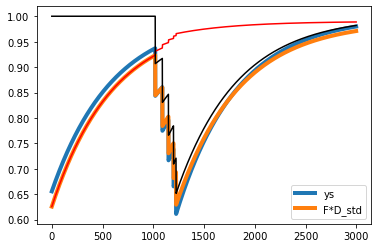

In [27]:
T = np.arange(0, 3000, 1)
spts = np.array([20, 90, 150, 200, 225]) + 1000


ys = [0.655]
usd = 0.1
tausd = 600
for t in T:
    ys_ = (1 - ys[-1]) / tausd
    if t in spts:
        ys_ -= usd * ys[-1]
    ys.append(ys[-1] + ys_)


    
F = [0.625]
D = [1]

taustf = 600
taustd = 600
U = 0.1
usd = 0.99

for t in T:
    f = (usd - F[-1]) / taustf
    if t in spts:
        f += U * (1 - F[-1])
    F.append(F[-1] + f)
    
    d = (1 - D[-1]) / taustd
    if t in spts:
        d -= 0.1 * D[-1] * F[-1] # !!!!!!!!!!!!!!!! <<<<<<<<<<<<<<<<<< !!!!!!!<<<<<<<<<!!!!!!!!!
    D.append(D[-1] + d)

FD = np.array(F) * np.array(D)

plt.plot(T, ys[1:], label='ys', lw=4.0)
plt.plot(T, FD[1:], label='F*D_std', lw=4.0)
plt.plot(T, F[1:], c='r')
plt.plot(T, D[1:], c='k')
plt.legend()

In [13]:
1.0/(1.0 + 0.1*0.05*600/5)

0.625